In [1]:
import gym
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from collections import deque
from gym.spaces.box import Box
from gym.spaces.discrete import Discrete
from copy import deepcopy
from typing import List, Tuple, Dict
from gym import Space
import torch.multiprocessing as mp
from gym.vector import SyncVectorEnv, AsyncVectorEnv
from copy import deepcopy
import pandas as pd

In [2]:
from deeprl.common.utils import to_torch

In [3]:
from deeprl.common.utils import net_gym_space_dims, discount_cumsum, to_torch, compute_td_deltas, compute_gae_and_v_targets, normalise_adv, init_envs, minibatch_split
from deeprl.algos.a2c.a2c import A2C
from deeprl.algos.ppo.ppo import PPO
from deeprl.common.base import Network, Policy, CategoricalPolicy, GaussianPolicy

In [4]:
def collect_rollout(agent, envs):
    batch_components_shape = (agent.n_interactions, agent.num_workers)

    # Do this in the train function
    states_batch = torch.zeros(batch_components_shape + envs.single_observation_space.shape, dtype=torch.float).to(agent.device)
    actions_batch = torch.zeros(batch_components_shape + envs.single_action_space.shape, dtype=torch.float).to(agent.device)
    rewards_batch = torch.zeros(batch_components_shape).to(agent.device)
    dones_batch = torch.zeros(batch_components_shape).to(agent.device)
    next_states_batch = torch.zeros(batch_components_shape + envs.single_observation_space.shape).to(agent.device)

    # Put this into the rollout function
    states = deepcopy(envs.observations)

    for step in range(agent.n_interactions):
        
        actions = agent.choose_action(states)
        next_states, rewards, dones, info = envs.step(actions)
        
        
        states_batch[step] = to_torch(states, agent.device)
        actions_batch[step] = to_torch(actions, agent.device)
        rewards_batch[step] = to_torch(rewards, agent.device)
        dones_batch[step] = to_torch(dones, agent.device)
        next_states_batch[step] = to_torch(next_states, agent.device)

        states = next_states

    return states_batch, actions_batch, rewards_batch, dones_batch, next_states_batch


def process_rollout(agent, rollout):
    batches = [None for _ in range(num_workers)]
    states_batch, actions_batch, rewards_batch, dones_batch, next_states_batch = rollout
    for j in range(num_workers):
        batch = {}
        batch["states"] = states_batch[:, j]
        batch["actions"] = actions_batch[:, j]
        batch["rewards"] = rewards_batch[:, j]
        batch["dones"] = dones_batch[:, j]
        batch["next_states"] = next_states_batch[:, j]
        batch["advantages"], batch["v_targets"] = compute_gae_and_v_targets(agent.critic, batch, device, agent.gamma, agent.lam)
        batches[j] = batch
        # batch_reward = torch.reduce_sum(batch["rewards"])
        # batch_log = {"rewards_sum": batch_reward}

    concat_batch = {k: torch.concat([b[k] for b in batches]) for k in batches[0].keys()}

    return concat_batch

```assert len(concat_batch["states"]) == agent.n_interactions * num_workers
assert len(concat_batch["next_states"]) == agent.n_interactions * num_workers
assert concat_batch["states"].dtype == torch.float32
assert concat_batch["rewards"].shape == (agent.n_interactions * num_workers,)
assert concat_batch["dones"].shape == (agent.n_interactions * num_workers,)
assert concat_batch["actions"].shape == (agent.n_interactions * num_workers,)
assert (not concat_batch["advantages"].requires_grad)````

In [5]:
def update_from_batch(agent, batch):
    total_policy_loss = 0.
    total_critic_loss = 0.
    for _ in range(agent.num_train_passes):
        minibatches = minibatch_split(batch, agent.minibatch_size)
        for minibatch in minibatches:
            
            if agent.norm_adv:
                minibatch["advantages"] = normalise_adv(minibatch["advantages"])
                
            policy_loss = agent.update_policy(minibatch)
            critic_loss = agent.update_critic(minibatch)

            total_policy_loss += policy_loss[0]
            total_critic_loss += critic_loss[0]

    mean_policy_loss = total_policy_loss / agent.num_train_passes / len(minibatches)
    mean_critic_loss = total_critic_loss / agent.num_train_passes / len(minibatches)

    return mean_policy_loss, mean_critic_loss





In [6]:
env_name = "LunarLander-v2"
envs = gym.vector.make(env_name)
policy_layers = [
    (nn.Linear,
        {"in_features": net_gym_space_dims(envs.single_observation_space),
        "out_features": 128}),
    (nn.ReLU, {}),
    (nn.Linear,
        {"in_features": 128,
        "out_features": 64}),
    (nn.ReLU, {}),
    (nn.Linear,{"in_features": 64, "out_features": net_gym_space_dims(envs.single_action_space)}),
]

critic_layers = [
    (nn.Linear, {"in_features": net_gym_space_dims(envs.single_observation_space), "out_features": 128}),
    (nn.ReLU, {}),
    (nn.Linear,
        {"in_features": 128,
        "out_features": 64}),
    (nn.ReLU, {}),
    (nn.Linear, {"in_features": 64, "out_features": 1}),
]

a2c_args = {
    "gamma": 0.99,
    "env_name": env_name,
    "step_lim": 500,
    "policy": CategoricalPolicy(policy_layers),
    "policy_optimiser": optim.Adam,
    "policy_lr": 0.0005,
    "critic": Network(critic_layers),
    "critic_lr": 0.0005,
    "critic_optimiser": optim.Adam,
    "critic_criterion": nn.MSELoss(),
    "device": "cpu",
    "entropy_coef": 0.01,
    "n_interactions": 128,
    "num_train_passes": 10,
    "lam": 0.95,
    "num_eval_episodes": 15,
    "num_workers": 8,
    "minibatch_size": 256,
    "norm_adv": True,
    "multiprocess": False,
    "grad_clip_coef": 0.5,
    "loss_clip_coef": 0.2
}


In [7]:
envs.close()
agent = PPO(a2c_args)
num_workers = agent.num_workers
device=agent.device
env_name = "LunarLander-v2"


In [11]:
eval_log2 = agent.run_training(50)

(76.16923621647146, -0.019745660852640866, 90.66506938934326)
(74.85117100613398, -0.009736381657421588, 280.47219734191896)
(43.39636834932712, -0.01272790206130594, 224.9603485107422)
(-53.19115587821166, -0.01921850647777319, 51.35627660751343)
(-12.425688322580093, -0.020775373466312884, 35.92195067405701)
(14.957825511395626, -0.019909344054758547, 53.2541316986084)
(-34.07687554506379, -0.016267672227695585, 41.99267244338989)
(-28.49600682213992, -0.023223384749144316, 47.28826193809509)
(-70.82585234894125, -0.018834057892672718, 87.68543014526367)
(-138.42936404370442, -0.016179866361198947, 30.65526533126831)
(-65.67485266270145, -0.02581996370572597, 29.8840322971344)
(26.48093604112025, -0.01908288011327386, 16.58955636024475)
(30.264386109972094, -0.018821106222458184, 23.40396671295166)
(11.574993216079985, -0.011990447854623198, 105.07268943786622)
(-8.787030030333394, -0.013070606789551676, 49.36263761520386)
(69.47288377645476, -0.020231458963826297, 162.6146722793579)

In [12]:
eval += eval_log2

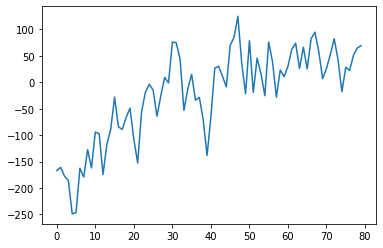

In [13]:
out = list(zip(*eval))

plt.plot(out[0])

In [13]:
batch_idc = np.arange(len(batch["states"]))

In [14]:
done_idc = batch_idc[1+(batch["dones"]==1.)]

In [15]:
pos = batch["states"][done_idc][:, 0]
vel = batch["states"][done_idc][:, 1]

In [16]:
bad_idc_pos = []
for i,p in enumerate(pos):
    if not (p >= -0.6 and p <= -0.4):
         bad_idc_pos.append((i, p))

bad_idc_vel = []
for j, v in enumerate(vel):
    if v != 0:

        bad_idc_vel.append(v)

In [19]:
bad_idc_pos
np.mean(bad_idc_vel)

172.24993885357466

In [24]:
tmp = rollout[0]
tmp[0][0]

tensor([-0.5505,  0.0000])

In [34]:
np.array([np.random.uniform(low=-0.6, high=-0.4), 0]).dtype

dtype('float64')

In [25]:
tmp[1][0]

tensor([-0.5493,  0.0012])

In [26]:
tmp = rollout[1]
tmp[0][0]

tensor(2.)

In [17]:
tmp[1][0]

tensor([-0.0142,  1.4199, -0.7142,  0.1855,  0.0146,  0.1258,  0.0000,  0.0000])

In [32]:
num_epochs = 30
for e in range(num_epochs):
    rollout = collect_rollout(agent, envs)
    batch = process_rollout(agent, rollout)
    p_loss, c_loss = update_from_batch(agent, batch)
    eval_r = np.mean(agent.run_eval())
    print(eval_r)
    r += [eval_r]

-173.19239503584075
-172.60251215317984
-178.4782370483543
-228.68811073600472
-246.84225198321047
-207.11016635853153
-205.44626132737216
-207.95082643312372
-201.9979350696185
-172.19229196084765
-262.0337850983584
-237.85800533438777
-244.02309146455246
-220.46089739264394
-259.1555643045256
-206.80026404794995
-197.90201883677557
-200.51229603439552
-223.56058137078335
-235.4760735838833
-159.09357970284955
-222.77981919057373
-247.60019583526
-162.9159315495674
-208.20999207544304
-216.18628703965487
-170.72826976549806
-121.02861376572392
-162.5490992979451
-195.1374250578408


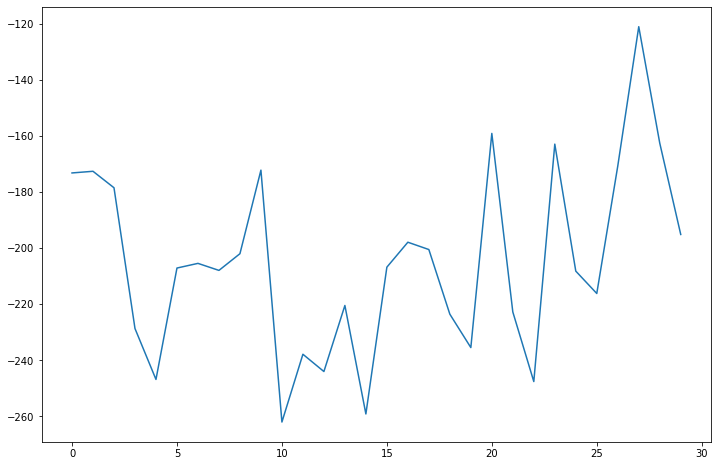

In [33]:
plt.figure(figsize=(12,8))
plt.plot(r)
